## PC Session 1 Solution

# **Machine Learning for Prediction**

**Author:**
[Anthony Strittmatter](http://www.anthonystrittmatter.com)


We estimate the hedonic prices of used-cars. For this purpose, we web-scrape data from the online auction platform *MyLemons*. We restrict the sample to BMW 320 series, Opel Astra, Mercedes C-class, VW Golf, and VW Passat. We select used-cars with a mileage between 10,000-200,000 km and an age between 1-20 years. 

We obtain the following variables:


|Variable name| Description|
|:----|:----|
|**Outcome variables** ||
|*first_price*| First asking price in 1,000 CHF |
|*final_price*| Transaction price in 1,000 CHF|
|*overprice*| Dummy indicating *first_price > final_price* |
|**Baseline covariates**| |
|*bmw_320, opel_astra, mercedes_c, vw_golf, vw_passat*| Dummies for the car make and model|
|*mileage*| Mileage of the used car (in 1,000 km)|
|*age_car_years*| Age of the used car (in years)|
|*diesel*| Dummy for diesel engines |
|*private_seller*| Dummy for private seller (as opposed to professional used car sellers) |
|*other_car_owner*| Number of previous caar owners |
|*guarantee*| Dummy indicating that the seller offers a guarantee for the used car|
|*maintenance_cert*| Dummy indicating that the seller has a complete maintenace certificate for the used car|
|*inspection*| Categorial variable for the duration until next general inspection (3 categories: new, 1-2 years, < 1 year) |
|*pm_green*| Dummy indicating that the used car has low particular matter emissions|
|*co2_em*| CO2 emssion (in g/km)|
|*euro_norm*| EURO emission norm under which the car is registered |
|*page_title* | Text in the title of the used car offer |


Furthermore, we generate some transformations of our covariates for later analysis. The transformed covariates are:

|Variable name| Description|
|:----|:----|
|**Additional covariates** ||
|*mileage2, mileage3, mileage4, age_car_years2, age_car_years3, age_car_years4*| Squared, cubic, and quadratic *mileage* and *age_car_years* |
|*dur_next_ins_0*| Dummy indicating that the duration until the next general inspection is less than a years |
|*dur_next_ins_1_2*| Dummy indicating that the duration until the next general inspection is between 1 and 2 years |
|*new_inspection*| Dummy indicating that the used car has a new general inspection |
|*euro_1, euro_2, euro_3, euro_4, euro_5, euro_6*| Dummies for EURO emission norms |

We store the prepared data in the file *used_cars.csv*.  


## Load Packages

In [1]:
########################  Load Packages  ########################

# List of required packages
pkgs <- c('tidyverse','glmnet','corrplot','plotmo')

# Load packages
for(pkg in pkgs){
    library(pkg, character.only = TRUE)
}

set.seed(10101) # set starting value for random number generator

print('All packages successfully installed and loaded.')


── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.8
✔ tidyr   0.8.2     ✔ stringr 1.3.1
✔ readr   1.2.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: Matrix

Attaching package: ‘Matrix’

The following object is masked from ‘package:tidyr’:

    expand

Loading required package: foreach

Attaching package: ‘foreach’

The following objects are masked from ‘package:purrr’:

    accumulate, when

Loaded glmnet 2.0-16

corrplot 0.84 loaded
Loading required package: plotrix
Loading required package: TeachingDemos


[1] "All packages successfully installed and loaded."


## Load Data Frame

We load the data frame and label the covariates. We select a subsample of 300 used-cars in order to decrease the computation time while you are testing your code. We can use the entire sample of 104,719 used cars after we are finised with programming.

In [2]:
########################  Load Data Frame  ########################

# Load data frame
data_raw <- read.csv("Data/used_cars.csv",header=TRUE, sep=",")

# Outcome Variable
outcomes <- c("first_price")

# Covariates/Features
covariates <- c("mileage","mileage2", "mileage3", "mileage4", "age_car_years", "age_car_years2", 
                "age_car_years3", "age_car_years4", "other_car_owner", "co2_em", "euro_1", 
                "euro_2", "euro_3", "euro_4", "euro_6", "dur_next_ins_0", 
                "dur_next_ins_1_2", "bmw_320", "opel_astra", "mercedes_c", 
                "vw_passat", "diesel", "private_seller", "guarantee", 
                "maintenance_cert", "pm_green") 

all_variables <- c(outcomes, covariates)

# Selection of Subsample size, max. 104,721 observations
# Select smaller subsample to decrease computation time
n_obs <- 300
df <- data_raw %>%
  dplyr::sample_n(n_obs) %>%
  dplyr::select(all_variables)

print('Data frame successfully loaded.')


[1] "Data frame successfully loaded."


## Descriptive Statistics

### Means and Standard Deviations

In [3]:
########################  Table with Descriptive Statistics  ########################

desc <- fBasics::basicStats(df) %>% t() %>% as.data.frame() %>% 
          select(Mean, Stdev, Minimum, Maximum, nobs)
print(round(desc, digits=1))


                        Mean       Stdev Minimum    Maximum nobs
first_price             14.7         6.5     3.2 3.8100e+01  300
mileage                102.2        50.3    10.0 2.0000e+02  300
mileage2             12971.1     10778.5   100.0 4.0000e+04  300
mileage3           1851120.6   2057807.8  1000.0 8.0000e+06  300
mileage4         284038226.0 387153789.8 10000.0 1.6000e+09  300
age_car_years            4.9         2.7     1.1 1.4000e+01  300
age_car_years2          31.6        36.9     1.2 1.9600e+02  300
age_car_years3         252.4       455.3     1.3 2.7440e+03  300
age_car_years4        2355.8      5683.3     1.5 3.8416e+04  300
other_car_owner          1.1         0.7     0.0 3.0000e+00  300
co2_em                 140.4        26.5    92.0 2.3800e+02  300
euro_1                   0.0         0.0     0.0 0.0000e+00  300
euro_2                   0.0         0.0     0.0 0.0000e+00  300
euro_3                   0.0         0.1     0.0 1.0000e+00  300
euro_4                   

### Correlation Matrix

Warning message in cor(df):
“the standard deviation is zero”

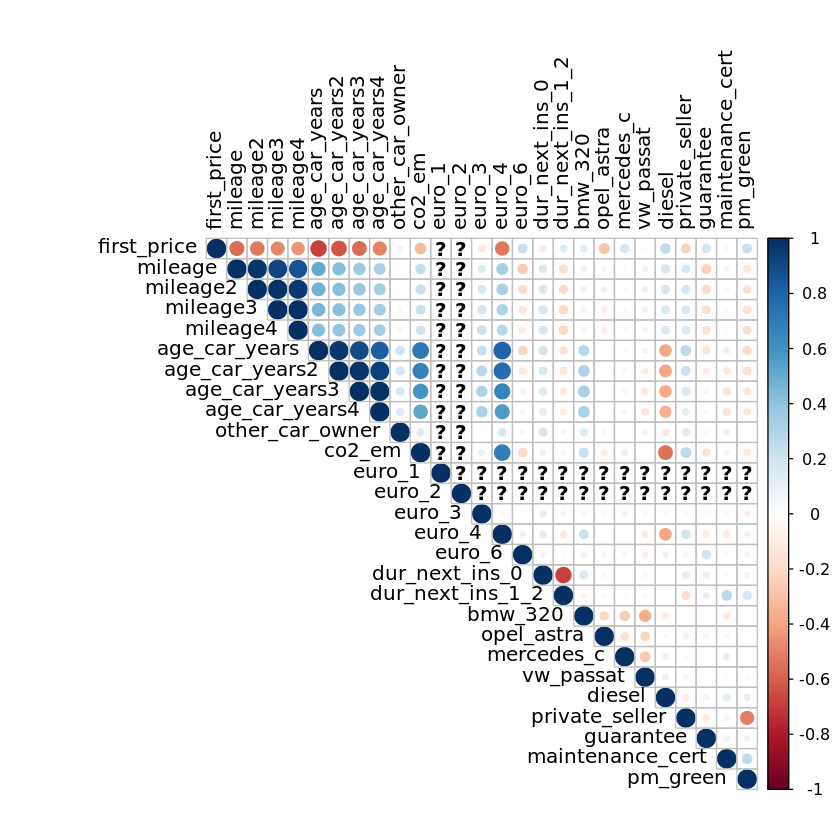

In [4]:
########################  Correlation Matrix  ########################

corr = cor(df)
corrplot(corr, type = "upper", tl.col = "black")


## Take Hold-Out-Sample 

We want to compare the relative prediction power of different estimation procedures based on the out-of-sample MSE and $R^2$. For this purpose, we create an hold-out-sample. Additionally, we generate 100 random variables which are unrelated to the used-car prices. These variables create additional noise in the estimation. Ideally, the Lasso approach should not select those variables. 

In [5]:
########################  Take Hold-Out-Sample  ########################

df_part <- modelr::resample_partition(df, c(obs = 0.8, hold_out = 0.2))
df_obs <- as.data.frame(df_part$obs) # Training and estimation sample
df_hold_out <- as.data.frame(df_part$hold_out) # Hold-out-sample

# Outcomes
first_price_obs <- as.matrix(df_obs[,1])
first_price_hold_out <- as.matrix(df_hold_out[,1])

# Generate some noisy covariates to disturbe the estimation
noise <- c("noise1", "noise2", "noise3", "noise4", "noise5", "noise6", "noise7", "noise8", "noise9", "noise10", 
           "noise11", "noise12", "noise13", "noise14", "noise15", "noise16", "noise17", "noise18", "noise19", "noise20", 
           "noise21", "noise22", "noise23", "noise24", "noise25", "noise26", "noise27", "noise28", "noise29", "noise30", 
           "noise31", "noise32", "noise33", "noise34", "noise35", "noise36", "noise37", "noise38", "noise39", "noise40",
           "noise41", "noise42", "noise43", "noise44", "noise45", "noise46", "noise47", "noise48", "noise49", "noise50", 
           "noise51", "noise52", "noise53", "noise54", "noise55", "noise56", "noise57", "noise58", "noise59", "noise60", 
           "noise61", "noise62", "noise63", "noise64", "noise65", "noise66", "noise67", "noise68", "noise69", "noise70", 
           "noise71", "noise72", "noise73", "noise74", "noise75", "noise76", "noise77", "noise78", "noise79", "noise80", 
           "noise81", "noise82", "noise83", "noise84", "noise85", "noise86", "noise87", "noise88", "noise89", "noise90", 
           "noise91", "noise92", "noise93", "noise94", "noise95", "noise96", "noise97", "noise98", "noise99", "noise100")
noise_obs <- matrix(data = rnorm(nrow(df_obs)*100),  nrow = nrow(df_obs), ncol = 100)
colnames(noise_obs) <- noise
noise_hold_out <- matrix(data = rnorm(nrow(df_hold_out)*100),  nrow = nrow(df_hold_out), ncol = 100)
colnames(noise_hold_out) <- noise
covariates <- c(covariates, noise)

# Covariates/Features
covariates_obs <- as.matrix(cbind(df_obs[,c(2:ncol(df_obs))],noise_obs))
covariates_hold_out <- as.matrix(cbind(df_hold_out[,c(2:ncol(df_hold_out))],noise_hold_out))

print('The data is now ready for your first analysis!')


[1] "The data is now ready for your first analysis!"


# OLS

We estimate the used-car prices using an OLS model which includes all (relevant and irrelavant) covariates.

**Replace parameters in questionsmarks.**

In [6]:
########################  OLS Model  ######################## 

# Setup the formula of the linear regression model
sumx <- paste(covariates, collapse = " + ")  
linear <- paste("first_price_obs",paste(sumx, sep=" + "), sep=" ~ ")
linear <- as.formula(linear)

# Setup the data for linear regression
data <- as.data.frame(cbind(first_price_obs,covariates_obs))

# Estimate OLS model
ols <- lm(linear, data)
# Some variables might be dropped because of perfect colinearity (121 covariates - 240 observations)

# In-sample fitted values
fit1_in <- predict.lm(ols)


Extrapolate fitted values to the hold-out-sample.

**Replace parameters in questionsmarks.**

In [7]:
# Out-of-sample fitted values
fit1_out <- predict.lm(ols, newdata = data.frame(covariates_hold_out))


Warning message in predict.lm(ols, newdata = data.frame(covariates_hold_out)):
“prediction from a rank-deficient fit may be misleading”

Evaluate the in- and out-of-sample performance using MSE and $R^2$.

In [8]:
# In-sample performance measures
mse1_in <- round(mean((first_price_obs - fit1_in)^2),digits=3)
rsquared_in <- round(1-mean((first_price_obs - fit1_in)^2)/mean((first_price_obs - mean(first_price_obs))^2),digits=3)
print(paste0("In-Sample MSE OLS: ", mse1_in))
print(paste0("In-Sample R-squared OLS: ", rsquared_in))

# Out-of-sample performance measures
mse1_out <- round(mean((first_price_hold_out - fit1_out)^2),digits=3)
rsquared_out <- round(1-mean((first_price_hold_out - fit1_out)^2)/mean((first_price_hold_out - mean(first_price_hold_out))^2),digits=3)
print(paste0("Out-of-Sample MSE OLS: ", mse1_out))
print(paste0("Out-of-Sample R-squared OLS: ", rsquared_out))


[1] "In-Sample MSE OLS: 3.72"
[1] "In-Sample R-squared OLS: 0.918"
[1] "Out-of-Sample MSE OLS: 16.155"
[1] "Out-of-Sample R-squared OLS: 0.372"


# LASSO

## Standard Lasso

The LASSO minimises the objective function
\begin{equation*}
\min_{\beta} \left\{ \sum_{i=1}^{N} \left( Y_i-  \beta_0 -\sum_{j=1}^{p}X_{ij}\beta_j \right)^2 + \lambda \sum_{j=1}^{p} |\beta_j| \right\}.
\end{equation*}
First we have to find the optimal tuning parameter $\lambda$ via cross-validation (CV).

**Replace parameters in questionsmarks.**

[1] "Lambda minimising CV-MSE: 0.12480896"
[1] "Lambda 1 standard error rule: 0.38114854"
[1] "Number of selected covariates (lambd.min): 56"
[1] "Number of selected covariates (lambd.1se): 15"


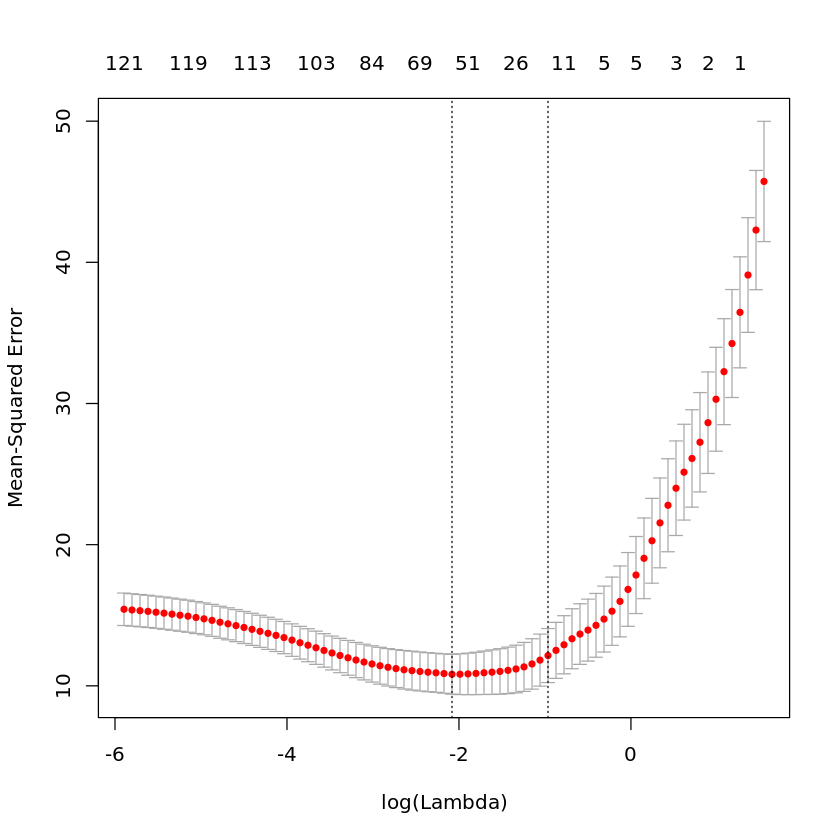

In [9]:
########################  CV-LASSO  ######################## 
p = 1 # 1 for LASSO, 0 for Ridge

set.seed(10101)
lasso.linear <- cv.glmnet(covariates_obs, first_price_obs, alpha=p, 
                          nlambda = 100, type.measure = 'mse')
# nlambda specifies the number of different lambda values on the grid (log-scale)
# type.measure spciefies that the optimality criteria is the MSE in CV-samples

# Plot MSE in CV-Samples for different values of lambda
plot(lasso.linear)

# Optimal Lambda
print(paste0("Lambda minimising CV-MSE: ", round(lasso.linear$lambda.min,digits=8)))
# 1 standard error rule reduces the number of included covariates
print(paste0("Lambda 1 standard error rule: ", round(lasso.linear$lambda.1se,digits=8)))

# Number of Non-Zero Coefficients
print(paste0("Number of selected covariates (lambd.min): ",lasso.linear$glmnet.fit$df[lasso.linear$glmnet.fit$lambda==lasso.linear$lambda.min]))
print(paste0("Number of selected covariates (lambd.1se): ",lasso.linear$glmnet.fit$df[lasso.linear$glmnet.fit$lambda==lasso.linear$lambda.1se]))


## Plot Lasso Structure

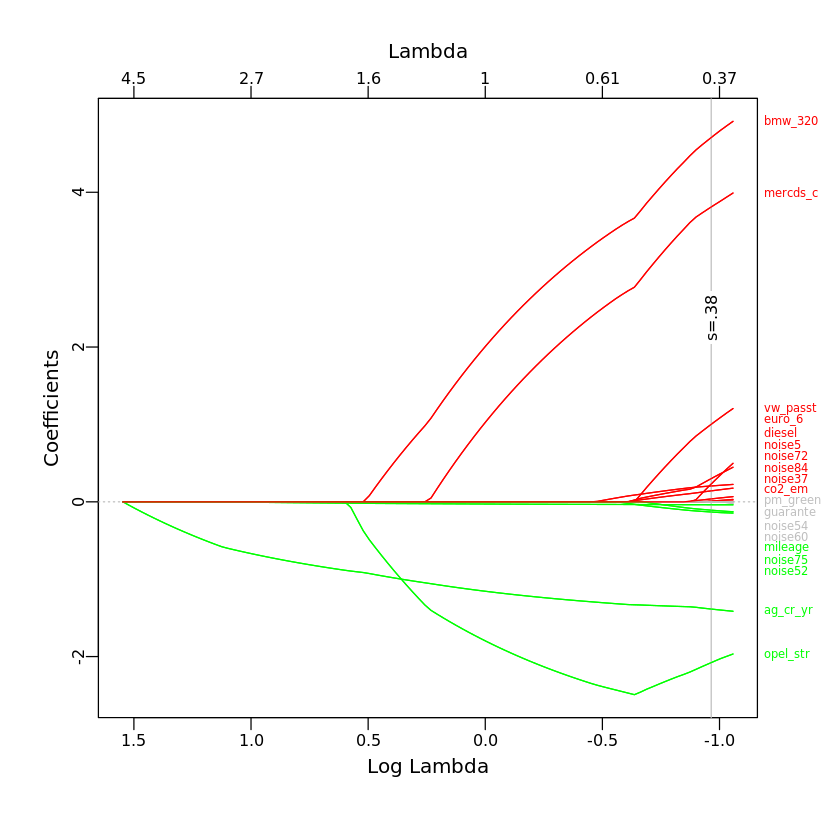

In [23]:
########################  Visualisation of LASSO  ######################## 

glmcoef<-coef(lasso.linear,lasso.linear$lambda.1se)
coef.increase<-dimnames(glmcoef[glmcoef[,1]>0,0])[[1]]
coef.decrease<-dimnames(glmcoef[glmcoef[,1]<0,0])[[1]]

lambda_min =  lasso.linear$glmnet.fit$lambda[29]/lasso.linear$glmnet.fit$lambda[1]
set.seed(10101)
mod <- glmnet(covariates_obs, first_price_obs, lambda.min.ratio = lambda_min, alpha=p)
maxcoef<-coef(mod,s=lambda_min)
coef<-dimnames(maxcoef[maxcoef[,1]!=0,0])[[1]]
allnames<-dimnames(maxcoef[maxcoef[,1]!=0,0])[[1]][order(maxcoef[maxcoef[,1]!=0,ncol(maxcoef)],decreasing=TRUE)]
allnames<-setdiff(allnames,allnames[grep("Intercept",allnames)])

#assign colors
cols<-rep("gray",length(allnames))
cols[allnames %in% coef.increase]<-"red"   
cols[allnames %in% coef.decrease]<- "green"

plot_glmnet(mod,label=TRUE,s=lasso.linear$lambda.1se,col= cols)


## Plot Lasso Coefficients

**Replace parameters in questionsmarks.**

In [11]:
########################  Plot LASSO Coefficients  ########################

print('LASSO coefficients')

glmcoef<-coef(lasso.linear, lasso.linear$lambda.1se)
print(glmcoef)
# the LASSO coefficients are biased because of the penalty term


[1] "LASSO coefficients"
127 x 1 sparse Matrix of class "dgCMatrix"
                            1
(Intercept)      22.790921634
mileage          -0.038003199
mileage2          .          
mileage3          .          
mileage4          .          
age_car_years    -1.386432505
age_car_years2    .          
age_car_years3    .          
age_car_years4    .          
other_car_owner   .          
co2_em            0.004393849
euro_1            .          
euro_2            .          
euro_3            .          
euro_4            .          
euro_6            0.233140258
dur_next_ins_0    .          
dur_next_ins_1_2  .          
bmw_320           4.712313702
opel_astra       -2.073343597
mercedes_c        3.813726294
vw_passat         1.004488463
diesel            0.297964828
private_seller    .          
guarantee         .          
maintenance_cert  .          
pm_green          .          
noise1            .          
noise2            .          
noise3            .          
no

## In-Sample Perforamce Measures

**Replace parameters in questionsmarks.**

In [12]:
######################## In-Sample Performance of LASSO  ######################## 

# Estimate LASSO model 
# Use Lambda that minizes CV-MSE
set.seed(10101)
lasso.fit.min <- glmnet(covariates_obs, first_price_obs, lambda = lasso.linear$lambda.min)
yhat.lasso.min <- predict(lasso.fit.min, covariates_obs)

# Use 1 standard error rule
set.seed(10101)
lasso.fit.1se <- glmnet(covariates_obs, first_price_obs, lambda = lasso.linear$lambda.1se)
yhat.lasso.1se <- predict(lasso.fit.1se, covariates_obs)

# In-sample performance measures
print(paste0("In-Sample MSE OLS: ", mse1_in))
print(paste0("In-Sample R-squared OLS: ", rsquared_in))

mse2_in <- round(mean((first_price_obs - yhat.lasso.min)^2),digits=3)
rsquared2_in <- round(1-mean((first_price_obs - yhat.lasso.min)^2)/mean((first_price_obs - mean(first_price_obs))^2),digits=3)
print(paste0("In-Sample MSE Lasso (lambda.min): ", mse2_in))
print(paste0("In-Sample R-squared Lasso (lambda.min): ", rsquared2_in))

mse3_in <- round(mean((first_price_obs - yhat.lasso.1se)^2),digits=3)
rsquared3_in <- round(1-mean((first_price_obs - yhat.lasso.1se)^2)/mean((first_price_obs - mean(first_price_obs))^2),digits=3)
print(paste0("In-Sample MSE Lasso(lambda.1se): ", mse3_in))
print(paste0("In-Sample R-squared Lasso (lambda.1se): ", rsquared3_in))


[1] "In-Sample MSE OLS: 3.72"
[1] "In-Sample R-squared OLS: 0.918"
[1] "In-Sample MSE Lasso (lambda.min): 6.155"
[1] "In-Sample R-squared Lasso (lambda.min): 0.864"
[1] "In-Sample MSE Lasso(lambda.1se): 10.464"
[1] "In-Sample R-squared Lasso (lambda.1se): 0.769"


## Out-of-Sample Perforamce Measures

**Replace parameters in questionsmarks.**

In [13]:
######################## Out-of-Sample Performance of LASSO  ######################## 

# Extrapolate Lasso fitted values to hold-out-sample
yhat.lasso.min <- predict(lasso.fit.min, covariates_hold_out)
yhat.lasso.1se <- predict(lasso.fit.1se, covariates_hold_out)

# Out-of-sample performance measures
print(paste0("Out-of-Sample MSE OLS: ", mse1_out))
print(paste0("Out-of-Sample R-squared OLS: ", rsquared_out))

mse2_out <- round(mean((first_price_hold_out - yhat.lasso.min)^2),digits=3)
rsquared2_out <- round(1-mean((first_price_hold_out - yhat.lasso.min)^2)/mean((first_price_hold_out - mean(first_price_hold_out))^2),digits=3)
print(paste0("Out-of-Sample MSE Lasso (lambda.min): ", mse2_out))
print(paste0("Out-of-Sample R-squared Lasso (lambda.min): ", rsquared2_out))

mse3_out <- round(mean((first_price_hold_out - yhat.lasso.1se)^2),digits=3)
rsquared3_out <- round(1-mean((first_price_hold_out - yhat.lasso.1se)^2)/mean((first_price_hold_out - mean(first_price_hold_out))^2),digits=3)
print(paste0("Out-of-Sample MSE Lassso (lambda.1se): ", mse3_out))
print(paste0("Out-of-Sample R-squared Lasso (lambda.1se): ", rsquared3_out))


[1] "Out-of-Sample MSE OLS: 16.155"
[1] "Out-of-Sample R-squared OLS: 0.372"
[1] "Out-of-Sample MSE Lasso (lambda.min): 6.85"
[1] "Out-of-Sample R-squared Lasso (lambda.min): 0.734"
[1] "Out-of-Sample MSE Lassso (lambda.1se): 6.735"
[1] "Out-of-Sample R-squared Lasso (lambda.1se): 0.738"


We could improve the performance of the LASSO prediction by adding more covariates (e.g., interactions). We can check the performance of the Risge estimator by setting *p = 0*.

## Honest Inference Procedure

Create a training and estimation sample.

In [14]:
######################## Separate Training and Estimation Sample  ######################## 

df_obs2 <- as.data.frame(cbind(first_price_obs,covariates_obs))
df_part2 <-  modelr::resample_partition(df_obs2, c(obs = 0.5, hold_out = 0.5))
df_train <- as.data.frame(df_part2$obs) # Training sample
df_est <- as.data.frame(df_part2$hold_out) # Estimation sample

# Outcomes
first_price_train <- as.matrix(df_train[,1])
first_price_est <- as.matrix(df_est[,1])

# Covariates/Features
covariates_train <- as.matrix(df_train[,c(2:ncol(df_obs2))])
covariates_est <- as.matrix(df_est[,c(2:ncol(df_obs2))])


Use the $\lambda$ crossvalidated in the training sample to fit a LASSO model in the estimation sample. Extrapolate the fitted values  from the estimation sample to the hold-out-sample.

**Replace parameters in questionsmarks.**

[1] "Lambda 1 standard error rule: 0.6505038"
[1] "Number of selected covariates (lambd.1se): 4"


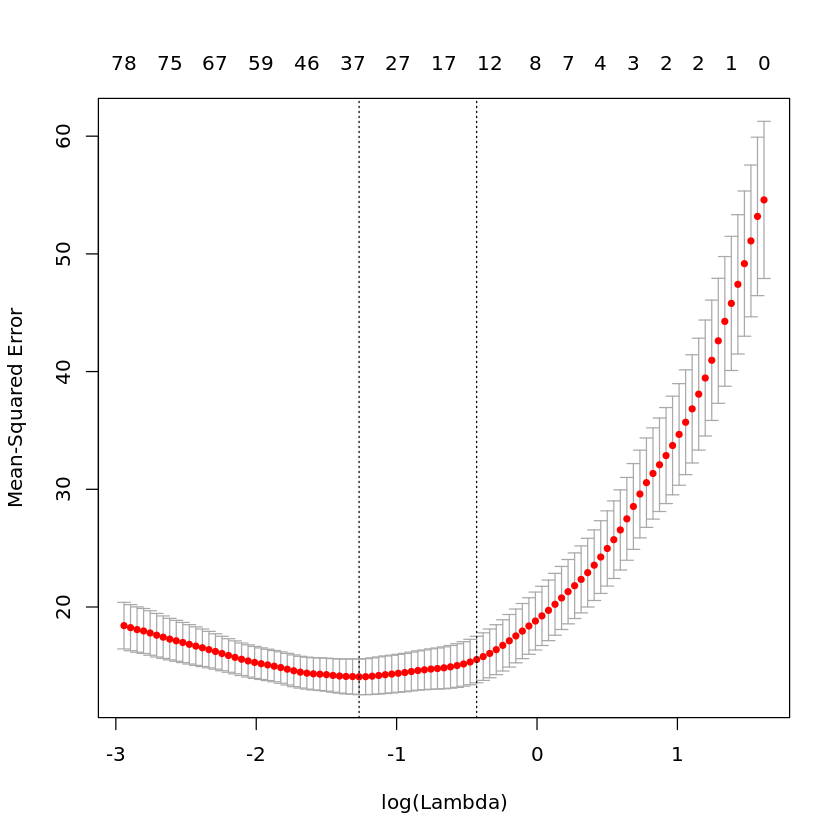

In [15]:
# Crossvalidate Lasso model
set.seed(10101)
lasso.linear2 <- cv.glmnet(covariates_train, first_price_train, alpha=p, 
                          nlambda = 100, type.measure = 'mse')
plot(lasso.linear2)

# Optimal Lambda
# 1 standard error rule reduces the number of included covariates
print(paste0("Lambda 1 standard error rule: ", round(lasso.linear2$lambda.1se,digits=8)))

# Number of Non-Zero Coefficients
print(paste0("Number of selected covariates (lambd.1se): ",lasso.linear2$glmnet.fit$df[lasso.linear2$glmnet.fit$lambda==lasso.linear2$lambda.1se]))

# Estimate LASSO model 
set.seed(10101)
lasso.fit2.1se <- glmnet(covariates_est, first_price_est, lambda = lasso.linear2$lambda.1se)
yhat2.lasso.1se <- predict(lasso.fit2.1se, covariates_hold_out)


Evaluate the performance in the hold-out-sample.

In [16]:
# Out-of-sample performance measures
mse4_out <- round(mean((first_price_hold_out - yhat2.lasso.1se)^2),digits=3)
rsquared4_out <- round(1-mean((first_price_hold_out - yhat2.lasso.1se)^2)/mean((first_price_hold_out - mean(first_price_hold_out))^2),digits=3)

print(paste0("Out-of-Sample MSE OLS: ", mse1_out))
print(paste0("Out-of-Sample R-squared OLS: ", rsquared_out))

print(paste0("Out-of-Sample MSE Lassso (lambda.1se): ", mse3_out))
print(paste0("Out-of-Sample R-squared Lasso (lambda.1se): ", rsquared3_out))

print(paste0("Out-of-Sample MSE Honest Lassso (lambda.1se): ", mse4_out))
print(paste0("Out-of-Sample R-squared Honest Lasso (lambda.1se): ", rsquared4_out))


[1] "Out-of-Sample MSE OLS: 16.155"
[1] "Out-of-Sample R-squared OLS: 0.372"
[1] "Out-of-Sample MSE Lassso (lambda.1se): 6.735"
[1] "Out-of-Sample R-squared Lasso (lambda.1se): 0.738"
[1] "Out-of-Sample MSE Honest Lassso (lambda.1se): 9.394"
[1] "Out-of-Sample R-squared Honest Lasso (lambda.1se): 0.635"


## Cross-Fitting Procedure

Switch training and estimation sample and repeat the same procedure as above. Use the $\lambda$ crossvalidated in the estimation sample to fit a LASSO model in the training sample. Extrapolate the fitted values from the training sample to the hold-out-sample.

**Replace parameters in questionsmarks.**

[1] "Lambda 1 standard error rule: 0.5647796"
[1] "Number of selected covariates (lambd.1se): 4"


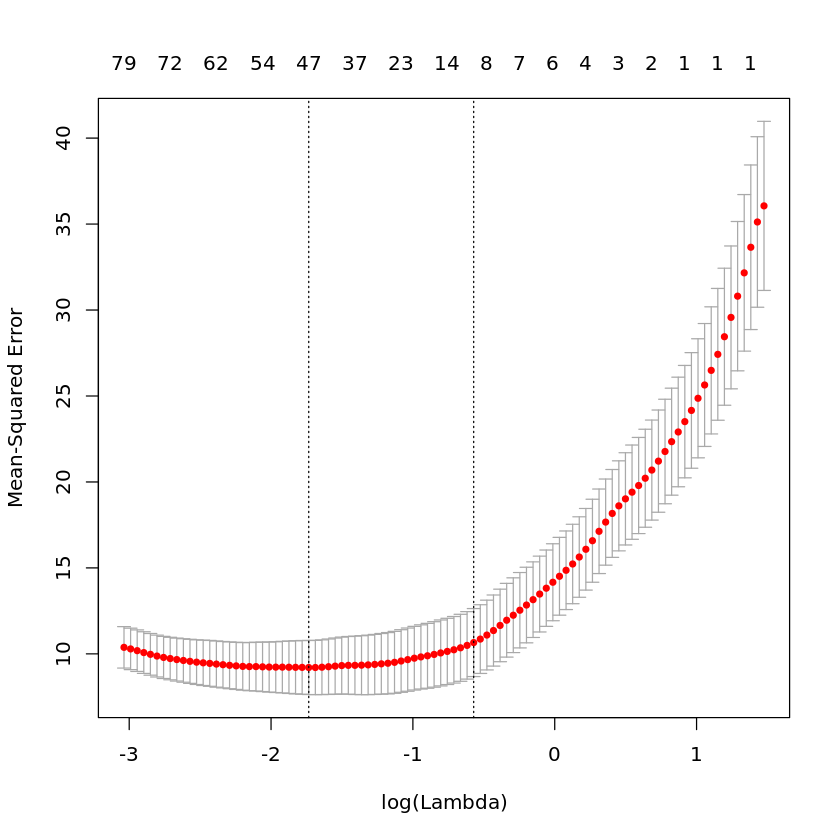

In [17]:
######################## Cross-Fitting  ######################## 

# Crossvalidate Lasso model
set.seed(10101)
lasso.linear3 <- cv.glmnet(covariates_est, first_price_est, alpha=p, 
                          nlambda = 100, type.measure = 'mse')
plot(lasso.linear3)

# Optimal Lambda
# 1 standard error rule reduces the number of included covariates
print(paste0("Lambda 1 standard error rule: ", round(lasso.linear3$lambda.1se,digits=8)))

# Number of Non-Zero Coefficients
print(paste0("Number of selected covariates (lambd.1se): ",lasso.linear3$glmnet.fit$df[lasso.linear3$glmnet.fit$lambda==lasso.linear3$lambda.1se]))

# Estimate LASSO model 
set.seed(10101)
lasso.fit3.1se <- glmnet(covariates_train, first_price_train, lambda = lasso.linear3$lambda.1se)
yhat3.lasso.1se_B <- predict(lasso.fit3.1se, covariates_hold_out)


Take the average of the fitted values which extrapolated from the training and estimaation samples.

In [18]:
# Take average of fitted values from both cross-fitting samples
yhat3.lasso.1se <- 0.5*(yhat2.lasso.1se + yhat3.lasso.1se_B)


Evaluate the performance in the hold-out-sample.

In [19]:
# Out-of-sample performance measures
mse5_out <- round(mean((first_price_hold_out - yhat3.lasso.1se)^2),digits=3)
rsquared5_out <- round(1-mean((first_price_hold_out - yhat3.lasso.1se)^2)/mean((first_price_hold_out - mean(first_price_hold_out))^2),digits=3)

print(paste0("Out-of-Sample MSE OLS: ", mse1_out))
print(paste0("Out-of-Sample R-squared OLS: ", rsquared_out))

print(paste0("Out-of-Sample MSE Lassso (lambda.1se): ", mse3_out))
print(paste0("Out-of-Sample R-squared Lasso (lambda.1se): ", rsquared3_out))

print(paste0("Out-of-Sample MSE Honest Lassso (lambda.1se): ", mse4_out))
print(paste0("Out-of-Sample R-squared Honest Lasso (lambda.1se): ", rsquared4_out))

print(paste0("Out-of-Sample MSE Cross-Fitted Honest Lassso (lambda.1se): ", mse5_out))
print(paste0("Out-of-Sample R-squared Cross-Fitted Honest Lasso (lambda.1se): ", rsquared5_out))


[1] "Out-of-Sample MSE OLS: 16.155"
[1] "Out-of-Sample R-squared OLS: 0.372"
[1] "Out-of-Sample MSE Lassso (lambda.1se): 6.735"
[1] "Out-of-Sample R-squared Lasso (lambda.1se): 0.738"
[1] "Out-of-Sample MSE Honest Lassso (lambda.1se): 9.394"
[1] "Out-of-Sample R-squared Honest Lasso (lambda.1se): 0.635"
[1] "Out-of-Sample MSE Cross-Fitted Honest Lassso (lambda.1se): 9.068"
[1] "Out-of-Sample R-squared Cross-Fitted Honest Lasso (lambda.1se): 0.647"


# Extra Exercises:

1. Estimate the Post-Lasso coefficients. Do they differ from the Lasso coeffieicents? Do the performances of the Lasso and Post-Lasso estimators differ?

2. Predict the used car prices using a Rdge instead of a Lasso model. Which estimator shows the better performance?

3. How do the results change when you increase the sample size to 104,721 observations?

2. Replace the outcome variable 'first_price' with the 'overprice' dummy. Fit a linear and logit Lasso model. How do the models differ from each other?